In [1]:
import pandas as pd
import numpy as np
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from header import *

In [2]:
data_root = initialize_data_root("AH")

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

## Import

In [4]:
q3mergeddata = pd.read_csv(data_root + '02-build/clean/2019q3/2019q3merged.csv')

## Hyperparameter Tuning of Random Forest

In [5]:
q3mergeddata['Clean_Number_of_Shares'] = q3mergeddata[['WeightedAverageNumberOfDilutedSharesOutstanding',
       'WeightedAverageNumberOfSharesOutstandingBasic']].max(axis = 1)

q3mergeddata['Clean_Number_of_Shares'] = q3mergeddata[['Clean_Number_of_Shares',
                                                       'CommonStockSharesOutstanding']].max(axis = 1)

q3mergeddata['Company_Value'] = q3mergeddata['Clean_Number_of_Shares'] * q3mergeddata['7_after']
q3mergeddata = q3mergeddata.drop(q3mergeddata[q3mergeddata.Company_Value == 0].index)
q3mergeddata = q3mergeddata.drop(['CommonStockSharesOutstanding','WeightedAverageNumberOfDilutedSharesOutstanding','WeightedAverageNumberOfSharesOutstandingBasic' ], axis = 1)
q3mergeddata['Company_Size_1'] = np.where(q3mergeddata['Company_Value'] <= 2000000000, 1, 0)
q3mergeddata['Company_Size_2'] = np.where(q3mergeddata['Company_Value'] >= 5000000000, 2, 1)
q3mergeddata['Company_Size'] = q3mergeddata['Company_Size_2'] - q3mergeddata['Company_Size_1']

q3mergeddata = q3mergeddata.drop(['Company_Size_1','Company_Size_2'], axis = 1)

q3mergeddata_processed  = pd.DataFrame(preprocessing.scale(q3mergeddata[q3mergeddata.columns[10:len(q3mergeddata.columns) - 7]]), columns =q3mergeddata.columns[10:len(q3mergeddata.columns) - 7] )



/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [ ]:
X_dt = pd.DataFrame(q3mergeddata_processed.copy())
Y_dt = pd.DataFrame(q3mergeddata['Company_Size'].copy())


rand_forest = RandomForestClassifier(criterion = 'entropy')
parameters = {'n_estimators':[5,10,15,20], 'min_samples_split':np.linspace(5, 100, 10, dtype = int, endpoint = True), 'min_samples_leaf':np.linspace(10, 150, 10, dtype = int, endpoint = True)}


model = GridSearchCV(rand_forest, parameters, cv = 10)
model.fit(X_dt, np.ravel(Y_dt))



In [ ]:
model.best_estimator_

### Do pairwise logistic regression(small medium, small large, medium large)

In [6]:
small_med = q3mergeddata.loc[q3mergeddata.Company_Size != 2]
small_large = q3mergeddata.loc[q3mergeddata.Company_Size != 1]
med_large = q3mergeddata.loc[q3mergeddata.Company_Size != 0]

pairwise = {'small-medium cap': small_med, 'small-large cap':small_large, 'medium-large cap':med_large}

In [7]:
labels = q3mergeddata.columns[10:len(q3mergeddata.columns) - 7]

log_reg = LogisticRegression(max_iter = 1000)
X = pd.DataFrame(small_med[labels].copy())
Y = pd.DataFrame(small_med.Company_Size.copy())
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)
log_reg.fit(X_train, np.ravel(Y_train))

logsm_decision = log_reg.decision_function(X_test)
logsm_fpr, logsm_tpr, _  = roc_curve(Y_test, logsm_decision)

logsm_auc = auc(logsm_fpr, logsm_tpr)    

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [8]:
log_reg = LogisticRegression(max_iter = 1000)
X = pd.DataFrame(small_large[labels].copy())
Y = pd.DataFrame(np.where(small_large.Company_Size.copy() == 0, 0, 1))

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)
log_reg.fit(X_train, np.ravel(Y_train))

logsl_decision = log_reg.decision_function(X_test)
logsl_fpr, logsl_tpr, _  = roc_curve(Y_test, logsl_decision)
logsl_auc = auc(logsl_fpr, logsl_tpr)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [9]:
labels = q3mergeddata.columns[10:len(q3mergeddata.columns) - 7]

log_reg = LogisticRegression(max_iter = 1000)
X = pd.DataFrame(med_large[labels].copy())
Y = pd.DataFrame(np.where(med_large.Company_Size.copy() == 1, 0, 1))
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30)
log_reg.fit(X_train, np.ravel(Y_train))

logml_decision = log_reg.decision_function(X_test)
logml_fpr, logml_tpr, _  = roc_curve(Y_test, logml_decision)

logml_auc = auc(logml_fpr, logml_tpr)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


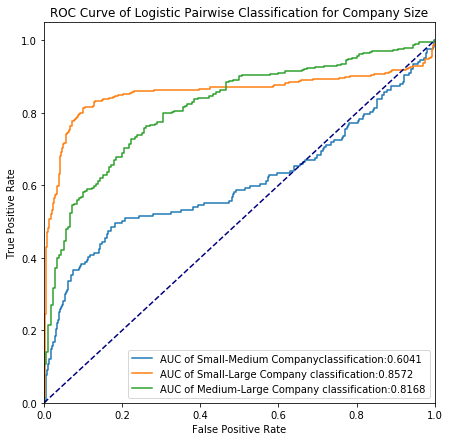

In [20]:
plt.figure(figsize = (7,7))
plt.plot(logsm_fpr, logsm_tpr, label = 'AUC of Small-Medium Companyclassification:'+"{0:.4f}".format(logsm_auc))
plt.plot(logsl_fpr, logsl_tpr, label = 'AUC of Small-Large Company classification:'+"{0:.4f}".format(logsl_auc))
plt.plot(logml_fpr, logml_tpr, label = 'AUC of Medium-Large Company classification:'+"{0:.4f}".format(logml_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Pairwise Classification for Company Size')
plt.legend(loc="lower right")
plt.savefig(data_root+'Pairwise_ComparisonROC.png')

### Tune Logistic Regression for binary case Rerun import

In [73]:
q3mergeddata['Clean_Number_of_Shares'] = q3mergeddata[['WeightedAverageNumberOfDilutedSharesOutstanding',
       'WeightedAverageNumberOfSharesOutstandingBasic']].max(axis = 1)

q3mergeddata['Clean_Number_of_Shares'] = q3mergeddata[['Clean_Number_of_Shares',
                                                       'CommonStockSharesOutstanding']].max(axis = 1)

q3mergeddata['Company_Value'] = q3mergeddata['Clean_Number_of_Shares'] * q3mergeddata['7_after']
q3mergeddata = q3mergeddata.drop(q3mergeddata[q3mergeddata.Company_Value == 0].index)
q3mergeddata = q3mergeddata.drop(['CommonStockSharesOutstanding','WeightedAverageNumberOfDilutedSharesOutstanding','WeightedAverageNumberOfSharesOutstandingBasic' ], axis = 1)
q3mergeddata['Company_Size'] = np.where(q3mergeddata['Company_Value'] > 5000000000, 1, 0)
q3mergeddata_processed  = pd.DataFrame(preprocessing.scale(q3mergeddata[q3mergeddata.columns[10:len(q3mergeddata.columns) - 7]]), columns =q3mergeddata.columns[10:len(q3mergeddata.columns) - 7] )

c = [10**i for i in range(-8, 2)]  

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [74]:
X_dt = pd.DataFrame(q3mergeddata_processed.copy())
Y_dt = pd.DataFrame(q3mergeddata['Company_Size'].copy())


log_reg = LogisticRegression()
parameters = {'penalty':('l1', 'l2'), 'C':c}


model = GridSearchCV(log_reg, parameters, cv = 10)
model.fit(X_dt, np.ravel(Y_dt))


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01,
                               0.1, 1, 10],
                         'penalty': ('l1', 'l2')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [75]:
model.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)